#### VARIABLES

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
basepath = "dades_tfg/data"
demographics = pd.read_csv(os.path.join(basepath, "demographics.csv"))
demographics_N = pd.read_csv(os.path.join(basepath, "demographics_N.csv"))
nodes = pd.read_csv(os.path.join(basepath, "nodes.csv"))
basepath_FA = os.path.join(basepath, "FA")
basepath_GM = os.path.join(basepath, "GM")
basepath_RS = os.path.join(basepath, "RS")

In [3]:
filenames = ["{:04d}.csv".format(x) for x in demographics["id"]]

In [4]:
data_FA = np.zeros(shape=(len(filenames), 76, 76))
data_GM = np.zeros(shape=(len(filenames), 76, 76))
data_RS = np.zeros(shape=(len(filenames), 76, 76))

In [5]:
for i, filename in enumerate(filenames):
    df_FA = pd.read_csv(os.path.join(basepath_FA, filename), header=None)
    data_FA[i,:,:] = df_FA.values
    
    df_GM = pd.read_csv(os.path.join(basepath_GM, filename), header=None)
    data_GM[i,:,:] = df_GM.values
    
    df_RS = pd.read_csv(os.path.join(basepath_RS, filename), header=None)
    data_RS[i,:,:] = df_RS.values

In [6]:
basepath_FA_N = "dades_tfg/data/Naples/DTI_networks"
basepath_GM_N = "dades_tfg/data/Naples/GM_networks"
basepath_RS_N = "dades_tfg/data/Naples/rsfmri_networks"

# Listar nombres de archivos CSV en cada carpeta
filenames_FA_N = sorted([f for f in os.listdir(basepath_FA_N) if f.endswith('.csv')])
filenames_GM_N = sorted([f for f in os.listdir(basepath_GM_N) if f.endswith('.csv')])
filenames_RS_N = sorted([f for f in os.listdir(basepath_RS_N) if f.endswith('.csv')])

In [7]:
# Inicializar arrays para almacenar los datos
data_FA_N = np.zeros((len(filenames_FA_N), 76, 76))  
data_GM_N = np.zeros((len(filenames_GM_N), 76, 76))
data_RS_N = np.zeros((len(filenames_RS_N), 76, 76))

In [8]:
# FA
for i, filename in enumerate(filenames_FA_N):
    df_FA_N = pd.read_csv(os.path.join(basepath_FA_N, filename), header=None)
    data_FA_N[i, :, :] = df_FA_N.values

#  GM
for i, filename in enumerate(filenames_GM_N):
    df_GM_N = pd.read_csv(os.path.join(basepath_GM_N, filename), header=None)
    data_GM_N[i, :, :] = df_GM_N.values

#  RS
for i, filename in enumerate(filenames_RS_N):
    df_RS_N = pd.read_csv(os.path.join(basepath_RS_N, filename), header=None)
    data_RS_N[i, :, :] = df_RS_N.values

In [9]:
num_samples_FA = len(data_FA)
num_samples_FA_N = len(data_FA_N)
num_samples_GM = len(data_FA)
num_samples_GM_N = len(data_FA_N)
num_samples_RS = len(data_FA)
num_samples_RS_N = len(data_FA_N)


data_FA_combined = np.zeros((num_samples_FA + num_samples_FA_N, 76, 76))  
data_FA_combined[:num_samples_FA, :, :] = data_FA
data_FA_combined[num_samples_FA:, :, :] = data_FA_N


data_GM_combined = np.zeros((num_samples_GM + num_samples_GM_N, 76, 76))  
data_GM_combined[:num_samples_GM, :, :] = data_GM
data_GM_combined[num_samples_GM:, :, :] = data_GM_N


data_RS_combined = np.zeros((num_samples_RS + num_samples_RS_N, 76, 76))  
data_RS_combined[:num_samples_RS, :, :] = data_RS
data_RS_combined[num_samples_RS:, :, :] = data_RS_N

In [10]:
demographics_N['mstype'] = demographics_N['mstype'].apply(lambda x: 0 if x == -1 else 1)

# Embeddings

In [11]:
from gensim.models.word2vec import Word2Vec
#!pip install node2vec
from node2vec import Node2Vec

### EMBEDDING PER INDIVIDU

In [12]:
individual_sequences = []

num_regions_per_individual = 76

for i in range(0, data_FA_combined.shape[0], num_regions_per_individual):
    individual_data = []
    for j in range(num_regions_per_individual):
        idx = i + j
        if idx < data_FA_combined.shape[0]:
            fa_str = f"fa_{data_FA_combined[idx].mean():.4f}"
            gm_str = f"gm_{data_GM_combined[idx].mean():.4f}"
            rs_str = f"rs_{data_RS_combined[idx].mean():.4f}"
            individual_data.extend([fa_str, gm_str, rs_str])
    individual_sequences.append(individual_data)

#document -> 1 individu embedding x individu
individual_model = Word2Vec(sentences=individual_sequences,
                            vector_size=50,
                            window=5,
                            min_count=1,
                            sg=1,
                            workers=4,
                            seed=42)

# Verificar
example_individual_embedding = individual_model.wv['fa_0.2402']
print(example_individual_embedding)


[ 0.00113606 -0.01888139 -0.00772895 -0.00244514  0.01910514  0.02018554
 -0.01384227  0.01609786 -0.0171045   0.01069989  0.01315454  0.01580461
 -0.01115625  0.01704938 -0.01540964  0.00076591 -0.00086626 -0.00786031
 -0.01999719  0.01112008 -0.00636248  0.00671529 -0.00403518 -0.00518628
  0.01562859 -0.0161751   0.0092443   0.01025486 -0.00535387 -0.01025156
 -0.01987389  0.01697585  0.01776912 -0.01018531 -0.01909557 -0.01521568
 -0.01727444  0.01202455  0.01641897 -0.01382851  0.00974878 -0.01204344
 -0.0045702   0.00311581  0.00918622  0.01478828 -0.01842475 -0.01187794
 -0.00891993 -0.00797611]


### RANDOMWALK Y DEEPWALK

In [13]:
import networkx as nx

In [14]:
def calculate_threshold(matrix):
    weights = matrix.values.flatten()
    mean_weight = weights.mean()
    std_weight = weights.std()
    median_weight = np.median(weights)
    threshold = mean_weight + std_weight  # media + 2 * std # mirar-ho amb la median i tornar mirar la FA
    return threshold

def create_graph_with_threshold(adj_matrix, nodes, threshold):
    G = nx.Graph()
    for index, row in nodes.iterrows():
        G.add_node(row['region_id'], name=row['region_name'])
    for i in range(adj_matrix.shape[0]):
        for j in range(i + 1, adj_matrix.shape[1]):
            if adj_matrix.iloc[i, j] > threshold:  # mayor q threshold
                G.add_edge(i+1, j+1, weight=adj_matrix.iloc[i, j])
    return G

In [15]:
graphs_FA = []

for i in range(data_FA_combined.shape[0]):
    print(f"Loading data_FA_combined[{i}]")
    adj_matrix = pd.DataFrame(data_FA_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_FA = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_FA.number_of_nodes()} nodos, {G_FA.number_of_edges()} aristas")

    graphs_FA.append(G_FA)

Loading data_FA_combined[0]
   Threshold = 0.4428
Grafo creado para muestra 0: 76 nodos, 505 aristas
Loading data_FA_combined[1]
   Threshold = 0.4126
Grafo creado para muestra 1: 76 nodos, 439 aristas
Loading data_FA_combined[2]
   Threshold = 0.4698
Grafo creado para muestra 2: 76 nodos, 497 aristas
Loading data_FA_combined[3]
   Threshold = 0.4459
Grafo creado para muestra 3: 76 nodos, 469 aristas
Loading data_FA_combined[4]
   Threshold = 0.4144
Grafo creado para muestra 4: 76 nodos, 476 aristas
Loading data_FA_combined[5]
   Threshold = 0.4652
Grafo creado para muestra 5: 76 nodos, 437 aristas
Loading data_FA_combined[6]
   Threshold = 0.4134
Grafo creado para muestra 6: 76 nodos, 504 aristas
Loading data_FA_combined[7]
   Threshold = 0.4109
Grafo creado para muestra 7: 76 nodos, 437 aristas
Loading data_FA_combined[8]
   Threshold = 0.4051
Grafo creado para muestra 8: 76 nodos, 444 aristas
Loading data_FA_combined[9]
   Threshold = 0.4399
Grafo creado para muestra 9: 76 nodos, 44

Grafo creado para muestra 80: 76 nodos, 466 aristas
Loading data_FA_combined[81]
   Threshold = 0.5079
Grafo creado para muestra 81: 76 nodos, 443 aristas
Loading data_FA_combined[82]
   Threshold = 0.4786
Grafo creado para muestra 82: 76 nodos, 442 aristas
Loading data_FA_combined[83]
   Threshold = 0.4587
Grafo creado para muestra 83: 76 nodos, 469 aristas
Loading data_FA_combined[84]
   Threshold = 0.4690
Grafo creado para muestra 84: 76 nodos, 438 aristas
Loading data_FA_combined[85]
   Threshold = 0.4657
Grafo creado para muestra 85: 76 nodos, 517 aristas
Loading data_FA_combined[86]
   Threshold = 0.4486
Grafo creado para muestra 86: 76 nodos, 460 aristas
Loading data_FA_combined[87]
   Threshold = 0.4856
Grafo creado para muestra 87: 76 nodos, 461 aristas
Loading data_FA_combined[88]
   Threshold = 0.4881
Grafo creado para muestra 88: 76 nodos, 438 aristas
Loading data_FA_combined[89]
   Threshold = 0.4466
Grafo creado para muestra 89: 76 nodos, 444 aristas
Loading data_FA_combi

Grafo creado para muestra 161: 76 nodos, 440 aristas
Loading data_FA_combined[162]
   Threshold = 0.4965
Grafo creado para muestra 162: 76 nodos, 481 aristas
Loading data_FA_combined[163]
   Threshold = 0.4507
Grafo creado para muestra 163: 76 nodos, 591 aristas
Loading data_FA_combined[164]
   Threshold = 0.4883
Grafo creado para muestra 164: 76 nodos, 513 aristas
Loading data_FA_combined[165]
   Threshold = 0.4740
Grafo creado para muestra 165: 76 nodos, 232 aristas
Loading data_FA_combined[166]
   Threshold = 0.4864
Grafo creado para muestra 166: 76 nodos, 268 aristas
Loading data_FA_combined[167]
   Threshold = 0.5013
Grafo creado para muestra 167: 76 nodos, 303 aristas
Loading data_FA_combined[168]
   Threshold = 0.4655
Grafo creado para muestra 168: 76 nodos, 214 aristas
Loading data_FA_combined[169]
   Threshold = 0.5215
Grafo creado para muestra 169: 76 nodos, 285 aristas
Loading data_FA_combined[170]
   Threshold = 0.4776
Grafo creado para muestra 170: 76 nodos, 216 aristas
Lo

Grafo creado para muestra 241: 76 nodos, 177 aristas
Loading data_FA_combined[242]
   Threshold = 0.5147
Grafo creado para muestra 242: 76 nodos, 295 aristas
Loading data_FA_combined[243]
   Threshold = 0.5117
Grafo creado para muestra 243: 76 nodos, 316 aristas
Loading data_FA_combined[244]
   Threshold = 0.5223
Grafo creado para muestra 244: 76 nodos, 263 aristas
Loading data_FA_combined[245]
   Threshold = 0.5229
Grafo creado para muestra 245: 76 nodos, 240 aristas
Loading data_FA_combined[246]
   Threshold = 0.5553
Grafo creado para muestra 246: 76 nodos, 215 aristas
Loading data_FA_combined[247]
   Threshold = 0.5210
Grafo creado para muestra 247: 76 nodos, 266 aristas
Loading data_FA_combined[248]
   Threshold = 0.5186
Grafo creado para muestra 248: 76 nodos, 223 aristas
Loading data_FA_combined[249]
   Threshold = 0.5047
Grafo creado para muestra 249: 76 nodos, 354 aristas
Loading data_FA_combined[250]
   Threshold = 0.5221
Grafo creado para muestra 250: 76 nodos, 212 aristas
Lo

In [16]:
import random
num_walks = 10  # Número de caminatas por nodo
walk_length = 10  # Longitud de cada caminata

def random_walk(graph, start_node, walk_length):
    walk = [start_node]
    while len(walk) < walk_length:
        neighbors = list(graph.neighbors(walk[-1]))
        if len(neighbors) > 0:
            next_node = random.choice(neighbors)
            walk.append(next_node)
        else:
            break
    return walk

models_fa = []


for G_fa in graphs_FA:
    walks_fa = []

    for node in G_fa.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_fa, start_node=node, walk_length=walk_length)
            walks_fa.append(walk)

    walks_fa = [[str(node) for node in walk] for walk in walks_fa]
    model_fa = Word2Vec(walks_fa, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_fa.append(model_fa)


In [17]:
graphs_GM = []

for i in range(data_GM_combined.shape[0]):
    print(f"Loading data_GM_combined[{i}]")
    adj_matrix = pd.DataFrame(data_GM_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_GM = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_GM.number_of_nodes()} nodos, {G_GM.number_of_edges()} aristas")

    
    graphs_GM.append(G_GM)

Loading data_GM_combined[0]
   Threshold = 0.1390
Grafo creado para muestra 0: 76 nodos, 310 aristas
Loading data_GM_combined[1]
   Threshold = 0.1418
Grafo creado para muestra 1: 76 nodos, 315 aristas
Loading data_GM_combined[2]
   Threshold = 0.1779
Grafo creado para muestra 2: 76 nodos, 331 aristas
Loading data_GM_combined[3]
   Threshold = 0.1624
Grafo creado para muestra 3: 76 nodos, 332 aristas
Loading data_GM_combined[4]
   Threshold = 0.1477
Grafo creado para muestra 4: 76 nodos, 319 aristas
Loading data_GM_combined[5]
   Threshold = 0.1489
Grafo creado para muestra 5: 76 nodos, 319 aristas
Loading data_GM_combined[6]
   Threshold = 0.1440
Grafo creado para muestra 6: 76 nodos, 321 aristas
Loading data_GM_combined[7]
   Threshold = 0.1464
Grafo creado para muestra 7: 76 nodos, 331 aristas
Loading data_GM_combined[8]
   Threshold = 0.1402
Grafo creado para muestra 8: 76 nodos, 325 aristas
Loading data_GM_combined[9]
   Threshold = 0.1527
Grafo creado para muestra 9: 76 nodos, 32

   Threshold = 0.1563
Grafo creado para muestra 82: 76 nodos, 324 aristas
Loading data_GM_combined[83]
   Threshold = 0.1845
Grafo creado para muestra 83: 76 nodos, 328 aristas
Loading data_GM_combined[84]
   Threshold = 0.1568
Grafo creado para muestra 84: 76 nodos, 332 aristas
Loading data_GM_combined[85]
   Threshold = 0.1241
Grafo creado para muestra 85: 76 nodos, 303 aristas
Loading data_GM_combined[86]
   Threshold = 0.1683
Grafo creado para muestra 86: 76 nodos, 329 aristas
Loading data_GM_combined[87]
   Threshold = 0.1587
Grafo creado para muestra 87: 76 nodos, 314 aristas
Loading data_GM_combined[88]
   Threshold = 0.1488
Grafo creado para muestra 88: 76 nodos, 327 aristas
Loading data_GM_combined[89]
   Threshold = 0.1660
Grafo creado para muestra 89: 76 nodos, 350 aristas
Loading data_GM_combined[90]
   Threshold = 0.1499
Grafo creado para muestra 90: 76 nodos, 314 aristas
Loading data_GM_combined[91]
   Threshold = 0.1614
Grafo creado para muestra 91: 76 nodos, 317 aristas

Grafo creado para muestra 161: 76 nodos, 328 aristas
Loading data_GM_combined[162]
   Threshold = 0.1460
Grafo creado para muestra 162: 76 nodos, 314 aristas
Loading data_GM_combined[163]
   Threshold = 0.1607
Grafo creado para muestra 163: 76 nodos, 336 aristas
Loading data_GM_combined[164]
   Threshold = 0.1499
Grafo creado para muestra 164: 76 nodos, 310 aristas
Loading data_GM_combined[165]
   Threshold = 0.6831
Grafo creado para muestra 165: 76 nodos, 11 aristas
Loading data_GM_combined[166]
   Threshold = 0.6736
Grafo creado para muestra 166: 76 nodos, 3 aristas
Loading data_GM_combined[167]
   Threshold = 0.6324
Grafo creado para muestra 167: 76 nodos, 352 aristas
Loading data_GM_combined[168]
   Threshold = 0.6231
Grafo creado para muestra 168: 76 nodos, 351 aristas
Loading data_GM_combined[169]
   Threshold = 0.6496
Grafo creado para muestra 169: 76 nodos, 51 aristas
Loading data_GM_combined[170]
   Threshold = 0.7035
Grafo creado para muestra 170: 76 nodos, 0 aristas
Loading 

Grafo creado para muestra 241: 76 nodos, 0 aristas
Loading data_GM_combined[242]
   Threshold = 0.6627
Grafo creado para muestra 242: 76 nodos, 2 aristas
Loading data_GM_combined[243]
   Threshold = 0.6775
Grafo creado para muestra 243: 76 nodos, 0 aristas
Loading data_GM_combined[244]
   Threshold = 0.6986
Grafo creado para muestra 244: 76 nodos, 2 aristas
Loading data_GM_combined[245]
   Threshold = 0.6561
Grafo creado para muestra 245: 76 nodos, 0 aristas
Loading data_GM_combined[246]
   Threshold = 0.6819
Grafo creado para muestra 246: 76 nodos, 0 aristas
Loading data_GM_combined[247]
   Threshold = 0.6693
Grafo creado para muestra 247: 76 nodos, 2 aristas
Loading data_GM_combined[248]
   Threshold = 0.6453
Grafo creado para muestra 248: 76 nodos, 12 aristas
Loading data_GM_combined[249]
   Threshold = 0.6930
Grafo creado para muestra 249: 76 nodos, 1 aristas
Loading data_GM_combined[250]
   Threshold = 0.6877
Grafo creado para muestra 250: 76 nodos, 0 aristas
Loading data_GM_combi

In [18]:
models_GM = []

for G_GM in graphs_GM:
    walks_GM = []

    for node in G_GM.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_GM, start_node=node, walk_length=walk_length)
            walks_GM.append(walk)

    walks_GM = [[str(node) for node in walk] for walk in walks_GM]
    model_GM = Word2Vec(walks_GM, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_GM.append(model_GM)

In [19]:
graphs_RS = []

for i in range(data_RS_combined.shape[0]):
    print(f"Loading data_RS_combined[{i}]")
    adj_matrix = pd.DataFrame(data_RS_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_RS = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_RS.number_of_nodes()} nodos, {G_RS.number_of_edges()} aristas")

    graphs_RS.append(G_RS)

Loading data_RS_combined[0]
   Threshold = 0.5150
Grafo creado para muestra 0: 76 nodos, 501 aristas
Loading data_RS_combined[1]
   Threshold = 0.4391
Grafo creado para muestra 1: 76 nodos, 495 aristas
Loading data_RS_combined[2]
   Threshold = 0.4281
Grafo creado para muestra 2: 76 nodos, 471 aristas
Loading data_RS_combined[3]
   Threshold = 0.5125
Grafo creado para muestra 3: 76 nodos, 530 aristas
Loading data_RS_combined[4]
   Threshold = 0.4063
Grafo creado para muestra 4: 76 nodos, 483 aristas
Loading data_RS_combined[5]
   Threshold = 0.3985
Grafo creado para muestra 5: 76 nodos, 449 aristas
Loading data_RS_combined[6]
   Threshold = 0.5568
Grafo creado para muestra 6: 76 nodos, 558 aristas
Loading data_RS_combined[7]
   Threshold = 0.5084
Grafo creado para muestra 7: 76 nodos, 504 aristas
Loading data_RS_combined[8]
   Threshold = 0.4038
Grafo creado para muestra 8: 76 nodos, 477 aristas
Loading data_RS_combined[9]
   Threshold = 0.4767
Grafo creado para muestra 9: 76 nodos, 48

Grafo creado para muestra 82: 76 nodos, 452 aristas
Loading data_RS_combined[83]
   Threshold = 0.4530
Grafo creado para muestra 83: 76 nodos, 511 aristas
Loading data_RS_combined[84]
   Threshold = 0.4502
Grafo creado para muestra 84: 76 nodos, 492 aristas
Loading data_RS_combined[85]
   Threshold = 0.5590
Grafo creado para muestra 85: 76 nodos, 507 aristas
Loading data_RS_combined[86]
   Threshold = 0.5565
Grafo creado para muestra 86: 76 nodos, 536 aristas
Loading data_RS_combined[87]
   Threshold = 0.4259
Grafo creado para muestra 87: 76 nodos, 446 aristas
Loading data_RS_combined[88]
   Threshold = 0.5665
Grafo creado para muestra 88: 76 nodos, 541 aristas
Loading data_RS_combined[89]
   Threshold = 0.5809
Grafo creado para muestra 89: 76 nodos, 535 aristas
Loading data_RS_combined[90]
   Threshold = 0.6913
Grafo creado para muestra 90: 76 nodos, 545 aristas
Loading data_RS_combined[91]
   Threshold = 0.3874
Grafo creado para muestra 91: 76 nodos, 454 aristas
Loading data_RS_combi

Grafo creado para muestra 164: 76 nodos, 483 aristas
Loading data_RS_combined[165]
   Threshold = 0.3211
Grafo creado para muestra 165: 76 nodos, 355 aristas
Loading data_RS_combined[166]
   Threshold = 0.4059
Grafo creado para muestra 166: 76 nodos, 383 aristas
Loading data_RS_combined[167]
   Threshold = 0.5202
Grafo creado para muestra 167: 76 nodos, 415 aristas
Loading data_RS_combined[168]
   Threshold = 0.4138
Grafo creado para muestra 168: 76 nodos, 402 aristas
Loading data_RS_combined[169]
   Threshold = 0.4123
Grafo creado para muestra 169: 76 nodos, 380 aristas
Loading data_RS_combined[170]
   Threshold = 0.4424
Grafo creado para muestra 170: 76 nodos, 416 aristas
Loading data_RS_combined[171]
   Threshold = 0.5318
Grafo creado para muestra 171: 76 nodos, 442 aristas
Loading data_RS_combined[172]
   Threshold = 0.4090
Grafo creado para muestra 172: 76 nodos, 395 aristas
Loading data_RS_combined[173]
   Threshold = 0.4468
Grafo creado para muestra 173: 76 nodos, 404 aristas
Lo

Grafo creado para muestra 243: 76 nodos, 421 aristas
Loading data_RS_combined[244]
   Threshold = 0.4206
Grafo creado para muestra 244: 76 nodos, 417 aristas
Loading data_RS_combined[245]
   Threshold = 0.4166
Grafo creado para muestra 245: 76 nodos, 425 aristas
Loading data_RS_combined[246]
   Threshold = 0.5021
Grafo creado para muestra 246: 76 nodos, 399 aristas
Loading data_RS_combined[247]
   Threshold = 0.3724
Grafo creado para muestra 247: 76 nodos, 369 aristas
Loading data_RS_combined[248]
   Threshold = 0.4705
Grafo creado para muestra 248: 76 nodos, 445 aristas
Loading data_RS_combined[249]
   Threshold = 0.4521
Grafo creado para muestra 249: 76 nodos, 431 aristas
Loading data_RS_combined[250]
   Threshold = 0.3954
Grafo creado para muestra 250: 76 nodos, 390 aristas
Loading data_RS_combined[251]
   Threshold = 0.4311
Grafo creado para muestra 251: 76 nodos, 374 aristas
Loading data_RS_combined[252]
   Threshold = 0.4630
Grafo creado para muestra 252: 76 nodos, 417 aristas
Lo

In [20]:
models_RS = []

for G_RS in graphs_RS:
    walks_RS = []

    for node in G_RS.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_RS, start_node=node, walk_length=walk_length)
            walks_RS.append(walk)

    walks_RS = [[str(node) for node in walk] for walk in walks_RS]
    model_RS = Word2Vec(walks_RS, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_RS.append(model_RS)

### MODELS

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [22]:
embeddings_FA = []
for model in models_fa:
    embedding_FA = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings_FA.append(embedding_FA)

X = np.array(embeddings_FA)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)


y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.8888888888888888
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.76      0.85        34
           1       0.85      0.98      0.91        47

    accuracy                           0.89        81
   macro avg       0.91      0.87      0.88        81
weighted avg       0.90      0.89      0.89        81



In [24]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.8765432098765432
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84        34
           1       0.85      0.96      0.90        47

    accuracy                           0.88        81
   macro avg       0.89      0.86      0.87        81
weighted avg       0.88      0.88      0.87        81



In [25]:
embeddings_GM = []
for model in models_GM:
    embedding_GM = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings_GM.append(embedding_GM)

X = np.array(embeddings_GM)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [27]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [28]:
embeddings_RS = []
for model in models_RS:
    embedding_RS = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings_RS.append(embedding_RS)

X = np.array(embeddings_RS)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7407407407407407
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.74      0.70        34
           1       0.80      0.74      0.77        47

    accuracy                           0.74        81
   macro avg       0.74      0.74      0.74        81
weighted avg       0.75      0.74      0.74        81



In [30]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.7654320987654321
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.65      0.70        34
           1       0.77      0.85      0.81        47

    accuracy                           0.77        81
   macro avg       0.76      0.75      0.75        81
weighted avg       0.76      0.77      0.76        81



In [31]:
embeddings_FA = pd.DataFrame(embeddings_FA)
embeddings_FA.to_csv('embeddings_FA.csv', index=False)

embeddings_GM = pd.DataFrame(embeddings_GM)
embeddings_GM.to_csv('embeddings_GM.csv', index=False)

embeddings_RS = pd.DataFrame(embeddings_RS)
embeddings_RS.to_csv('embeddings_RS.csv', index=False)

### AMB NODE2VEC

In [32]:
embeddings_FA_n2v = []

for G_fa in graphs_FA:
    node2vec = Node2Vec(G_fa, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_fa = node2vec.fit(window=5, min_count=1, sg=1)

    embedding_FA_n2v = np.mean([model_fa.wv[str(node)] for node in G_fa.nodes()], axis=0)
    embeddings_FA_n2v.append(embedding_FA_n2v)

X = np.array(embeddings_FA_n2v)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 641.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 744.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 870.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 905.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 842.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 959.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 816.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 831.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 906.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 890.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 896.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 374.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 788.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 920.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 803.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 949.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 920.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 958.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 732.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 775.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 768.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 847.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 804.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 762.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 662.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 853.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 819.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 329.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 808.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 972.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 865.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 787.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 916.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 830.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 805.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 746.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 829.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 357.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 906.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 813.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 789.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 847.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 871.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 757.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 845.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 763.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 825.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 856.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 885.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 848.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 758.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 702.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 838.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 884.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 897.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 875.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 382.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 920.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 852.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 809.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 810.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 824.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 825.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 805.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 901.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 792.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 814.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 830.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 768.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 866.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 363.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 835.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 794.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 622.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 854.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 833.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 705.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 794.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 806.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 860.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 890.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 827.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 855.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 364.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 707.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 694.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 746.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 763.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 756.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 799.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 728.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 724.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 737.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 765.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 650.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 716.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 756.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 717.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 780.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 869.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 808.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 734.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 350.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1097.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1062.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1134.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1244.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1009.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1145.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1312.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1188.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1190.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1319.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 813.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1081.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1217.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 816.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1160.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 922.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1211.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1012.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1264.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 421.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1248.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1115.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1000.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1247.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1194.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1299.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 965.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 904.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1087.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1160.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1046.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 801.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1079.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1084.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 822.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1562.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1156.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 964.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1089.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 392.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1275.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1190.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1166.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1302.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1175.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1063.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1017.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1065.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1279.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 966.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1044.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 977.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1095.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1151.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1064.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1124.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1188.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1169.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1132.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 367.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1242.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1063.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1116.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1044.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1174.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1163.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 997.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1050.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1095.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1348.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1182.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1058.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1271.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1122.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1186.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 932.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1310.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1247.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1222.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1313.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1135.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1279.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1313.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1160.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1262.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1242.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1063.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1134.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1230.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1247.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 385.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1074.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1160.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1354.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1062.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1188.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1160.91it/s]


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.8888888888888888
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87        34
           1       0.90      0.91      0.91        47

    accuracy                           0.89        81
   macro avg       0.89      0.88      0.89        81
weighted avg       0.89      0.89      0.89        81

Logistic Regression Accuracy: 0.8765432098765432
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        34
           1       0.89      0.89      0.89        47

    accuracy                           0.88        81
   macro avg       0.87      0.87      0.87        81
weighted avg       0.88      0.88      0.88        81

SVM AUC-ROC: 0.9167709637046308
Logistic Regression AUC-ROC: 0.9249061326658322


In [34]:
embeddings_GM_n2v = []

for G_GM in graphs_GM:
    node2vec = Node2Vec(G_GM, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_GM = node2vec.fit(window=5, min_count=1, sg=1)

    embedding_GM_n2v = np.mean([model_GM.wv[str(node)] for node in G_GM.nodes()], axis=0)
    embeddings_GM_n2v.append(embedding_GM_n2v)

X = np.array(embeddings_GM_n2v)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 976.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1062.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1217.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1062.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1062.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1023.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1035.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1086.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1073.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1189.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1134.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1137.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1062.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1124.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1059.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1116.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1136.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1268.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1062.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1217.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 934.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1121.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1109.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 352.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 999.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 831.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 941.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1087.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1219.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1035.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 904.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 952.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 992.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 986.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 826.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 874.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 970.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 710.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 855.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 922.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 649.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 700.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 835.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 868.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 839.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 776.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 845.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 805.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 887.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 843.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 769.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 223.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 685.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 725.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 931.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 765.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 748.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 733.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 782.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 867.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 837.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 879.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 889.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 694.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 758.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1021.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 681.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 836.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 815.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 804.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 805.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 789.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 764.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 795.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 255.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 709.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 875.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 896.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 932.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 905.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 806.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 813.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 796.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 679.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 768.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 847.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 937.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 900.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 812.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 902.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 705.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 929.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 857.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 746.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 867.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 749.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 813.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 766.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 261.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 751.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 880.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 860.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 707.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 902.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 878.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 799.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1015.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 843.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 997.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1036.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 747.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 866.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 748.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 808.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 867.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 741.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 755.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 247.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 833.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1016.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 724.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 817.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 966.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 682.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 812.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 717.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 788.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 684.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 699.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 848.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 824.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 967.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 701.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 716.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 724.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 737.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 654.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 760.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 758.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 254.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 906.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 685.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 796.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 869.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 735.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 839.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 882.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 749.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 810.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 736.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4057.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4974.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1015.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 845.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2272.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8269.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2782.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6997.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3567.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3303.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5427.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4558.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3734.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2443.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6959.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3190.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 551.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2261.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1464.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10139.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2831.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 343.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4317.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4127.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1518.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7468.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1724.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2346.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4371.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7143.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3331.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4914.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4321.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5571.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4777.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1065.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1351.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3692.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2394.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2271.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6250.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8097.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5540.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3333.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1071.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1324.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7600.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3944.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1812.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3924.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4248.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 698.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5895.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 422.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1880.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10001.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 11422.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6994.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12498.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5602.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8333.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8639.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12500.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6231.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4951.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8334.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3333.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4663.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3846.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10001.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6712.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7761.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9874.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4166.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1390.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9421.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7073.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8360.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4165.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10003.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7141.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7087.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9996.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7998.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7143.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3976.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4272.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1144.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 7654.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6618.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5120.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3402.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8374.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2275.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1526.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3862.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4166.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6255.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1664.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6001.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1023.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3311.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1423.85it/s]


In [35]:
embeddings_GM_n2v

[array([-6.83630705e-02,  2.87035480e-02,  1.37380317e-01, -1.07964024e-01,
        -1.84998140e-01, -2.26388380e-01, -2.45724805e-05,  2.36735165e-01,
        -3.03367376e-01, -2.59899765e-01,  2.86047310e-02,  9.96381566e-02,
         2.03989707e-02, -3.16192172e-02, -1.20036311e-01,  1.03474632e-01,
         2.31438681e-01,  1.26253277e-01, -4.39516932e-01, -9.87608731e-03,
         1.55498788e-01,  2.34662414e-01,  3.28239739e-01,  1.13660119e-01,
         1.94772765e-01], dtype=float32),
 array([-0.11527558,  0.11302902,  0.08445107, -0.04923634, -0.13547178,
        -0.1945364 ,  0.02880637,  0.23348548, -0.32938275, -0.24631783,
         0.12489102,  0.09796054,  0.00226376, -0.04665944,  0.02252961,
         0.14248198,  0.27464342,  0.07538942, -0.42241153,  0.03573808,
         0.17376569,  0.1743881 ,  0.35242224,  0.10797261,  0.11769109],
       dtype=float32),
 array([-0.07269269, -0.05096075,  0.25683278, -0.03711497, -0.20113602,
        -0.15118483,  0.04070797,  0.195

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)


y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81

SVM AUC-ROC: 0.9073842302878599
Logistic Regression AUC-ROC: 0.8735919899874844


In [37]:
embeddings_RS_n2v = []

for G_RS in graphs_RS:
    node2vec = Node2Vec(G_RS, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_RS = node2vec.fit(window=5, min_count=1, sg=1)

    embedding_RS_n2v = np.mean([model_RS.wv[str(node)] for node in G_RS.nodes()], axis=0)
    embeddings_RS_n2v.append(embedding_RS_n2v)

X = np.array(embeddings_RS_n2v)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 514.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 599.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 624.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 625.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 660.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 660.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 207.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 634.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 694.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 672.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 673.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 759.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 556.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 625.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 643.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 683.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 769.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 626.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 646.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 649.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 518.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 590.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 562.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 583.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 458.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 594.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 635.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 516.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 603.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 613.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 607.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 205.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 617.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 674.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 571.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 540.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 512.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 499.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 589.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 660.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 566.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 569.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 661.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 712.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 811.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 920.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 332.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 847.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 914.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 874.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 860.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 862.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 904.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 886.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 869.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 840.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 850.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 842.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 330.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 871.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 873.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 723.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 804.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 755.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 819.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 873.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 941.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 793.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 876.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 941.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 881.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 918.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 882.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 877.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 915.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 773.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 746.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 858.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 918.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 899.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 903.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 903.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 935.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 858.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 335.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 916.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 874.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 978.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 867.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 920.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 865.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 936.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 900.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 922.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 861.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 978.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 326.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 871.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 954.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1040.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 926.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 933.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 978.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1020.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 940.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1039.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 978.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 978.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 322.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 999.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 875.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 885.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 871.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 853.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 917.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 978.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1018.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 908.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 956.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1085.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1020.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 978.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 941.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 331.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1018.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 921.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 918.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 907.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 962.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 961.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1011.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1018.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 951.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 938.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 939.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 943.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 319.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 952.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 926.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 998.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 941.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 960.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1018.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 903.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 924.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 979.01it/s]


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)

y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.7037037037037037
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.56      0.61        34
           1       0.72      0.81      0.76        47

    accuracy                           0.70        81
   macro avg       0.70      0.68      0.69        81
weighted avg       0.70      0.70      0.70        81

Logistic Regression Accuracy: 0.7037037037037037
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.53      0.60        34
           1       0.71      0.83      0.76        47

    accuracy                           0.70        81
   macro avg       0.70      0.68      0.68        81
weighted avg       0.70      0.70      0.70        81

SVM AUC-ROC: 0.7659574468085107
Logistic Regression AUC-ROC: 0.7659574468085106


In [39]:
node_id_to_name = dict(zip(nodes['region_id'], nodes['region_name']))
print(node_id_to_name)

{1: 'ctx.lh.caudalanteriorcingulate', 2: 'ctx.lh.caudalmiddlefrontal', 3: 'ctx.lh.cuneus', 4: 'ctx.lh.entorhinal', 5: 'ctx.lh.fusiform', 6: 'ctx.lh.inferiorparietal', 7: 'ctx.lh.inferiortemporal', 8: 'ctx.lh.isthmuscingulate', 9: 'ctx.lh.lateraloccipital', 10: 'ctx.lh.lateralorbitofrontal', 11: 'ctx.lh.lingual', 12: 'ctx.lh.medialorbitofrontal', 13: 'ctx.lh.middletemporal', 14: 'ctx.lh.parahippocampal', 15: 'ctx.lh.paracentral', 16: 'ctx.lh.parsopercularis', 17: 'ctx.lh.parsorbitalis', 18: 'ctx.lh.parstriangularis', 19: 'ctx.lh.pericalcarine', 20: 'ctx.lh.postcentral', 21: 'ctx.lh.posteriorcingulate', 22: 'ctx.lh.precentral', 23: 'ctx.lh.precuneus', 24: 'ctx.lh.rostralanteriorcingulate', 25: 'ctx.lh.rostralmiddlefrontal', 26: 'ctx.lh.superiorfrontal', 27: 'ctx.lh.superiorparietal', 28: 'ctx.lh.superiortemporal', 29: 'ctx.lh.supramarginal', 30: 'ctx.lh.transversetemporal', 31: 'ctx.lh.insula', 32: 'left.thalamus', 33: 'left.caudate', 34: 'left.putamen', 35: 'left.pallidum', 36: 'left.hi

In [40]:
def recommend(node):
    similar_nodes = model_fa.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  # Convertir el id del nodo a nombre 
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.lh.precuneus: Similaridad = 1.00
Nodo ctx.rh.superiorparietal: Similaridad = 0.99
Nodo ctx.lh.pericalcarine: Similaridad = 0.99
Nodo left.pallidum: Similaridad = 0.99
Nodo ctx.rh.precuneus: Similaridad = 0.99
Nodo left.putamen: Similaridad = 0.99
Nodo ctx.rh.inferiortemporal: Similaridad = 0.99
Nodo ctx.rh.parahippocampal: Similaridad = 0.99
Nodo ctx.rh.inferiorparietal: Similaridad = 0.99
Nodo ctx.rh.transversetemporal: Similaridad = 0.99


In [41]:
def recommend(node):
    similar_nodes = model_GM.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.rh.parahippocampal: Similaridad = 0.52
Nodo ctx.rh.precentral: Similaridad = 0.34
Nodo ctx.lh.middletemporal: Similaridad = 0.30
Nodo ctx.rh.inferiortemporal: Similaridad = 0.29
Nodo ctx.lh.posteriorcingulate: Similaridad = 0.28
Nodo ctx.rh.fusiform: Similaridad = 0.28
Nodo left.amygdala: Similaridad = 0.28
Nodo ctx.rh.lateralorbitofrontal: Similaridad = 0.28
Nodo ctx.lh.parsorbitalis: Similaridad = 0.27
Nodo left.caudate: Similaridad = 0.26


In [42]:
def recommend(node):
    similar_nodes = model_RS.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.rh.cuneus: Similaridad = 1.00
Nodo ctx.lh.lingual: Similaridad = 1.00
Nodo ctx.lh.lateraloccipital: Similaridad = 1.00
Nodo ctx.rh.pericalcarine: Similaridad = 1.00
Nodo ctx.rh.lateraloccipital: Similaridad = 1.00
Nodo ctx.lh.fusiform: Similaridad = 1.00
Nodo ctx.lh.pericalcarine: Similaridad = 1.00
Nodo ctx.rh.lingual: Similaridad = 0.99
Nodo ctx.rh.fusiform: Similaridad = 0.97
Nodo ctx.rh.precuneus: Similaridad = 0.79


In [43]:
G_fa.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76))

In [44]:
import matplotlib.pyplot as plt

Número de nodos: 76
Número de aristas: 2925


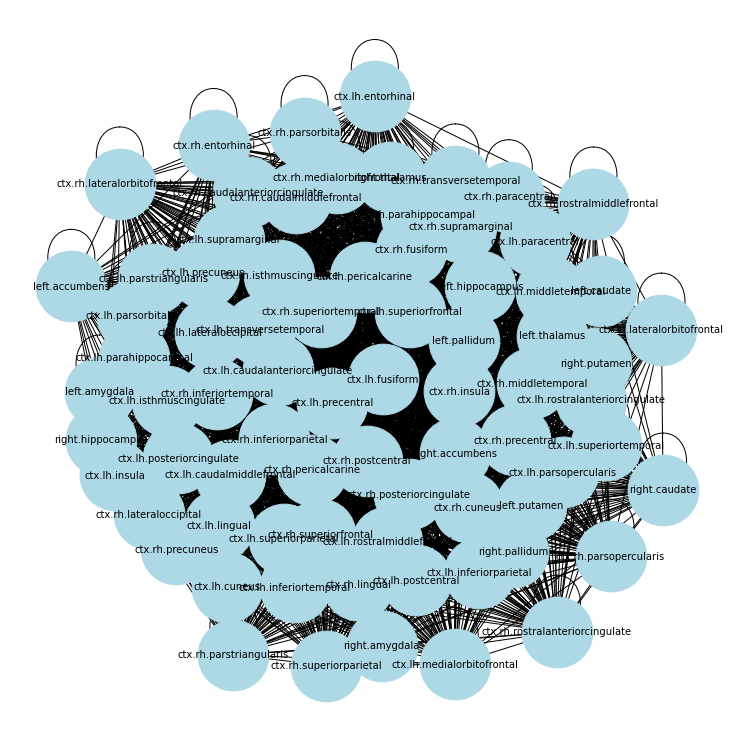

In [45]:
G_namedd = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_namedd.add_node(node_name) 

for node_id in model_fa.wv.index_to_key:  
    for node1, similarity in model_fa.wv.most_similar(0, topn=777): #ITERAR SOBRE UNO CON MAXIMO DE TOPN q como max es 76
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_namedd.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_namedd.number_of_nodes()}")
print(f"Número de aristas: {G_namedd.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_namedd)  
nx.draw(G_namedd, pos, with_labels=True, node_size=5000, node_color="lightblue", font_size=10)
plt.show()

Número de nodos: 76
Número de aristas: 265


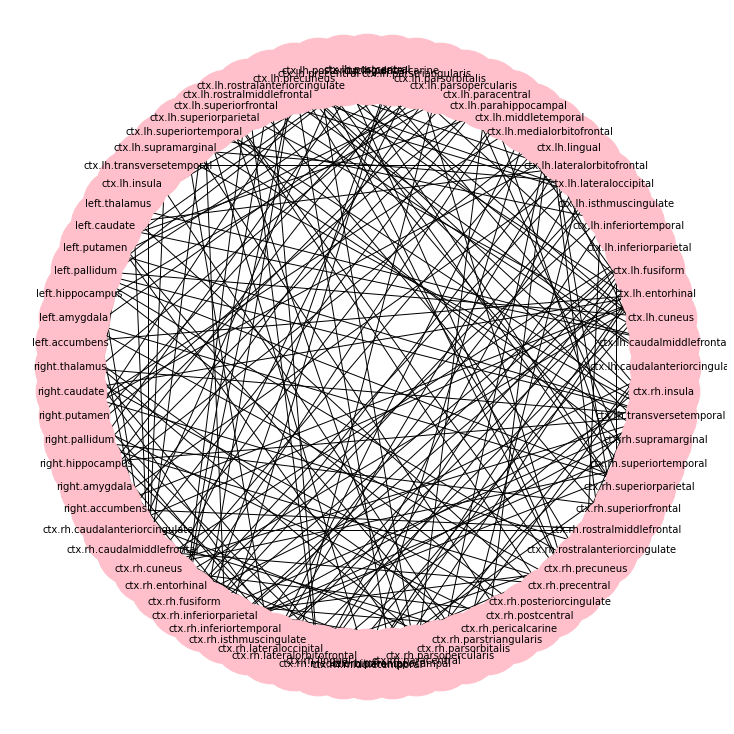

In [46]:
G_named_FA = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_named_FA.add_node(node_name)  

for node_id in model_fa.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_fa.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_FA.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_FA.number_of_nodes()}")
print(f"Número de aristas: {G_named_FA.number_of_edges()}")



plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_FA) 
nx.draw(G_named_FA, pos, with_labels=True, node_size=5000, node_color="pink", font_size=10)
plt.show()

Número de nodos: 76
Número de aristas: 270


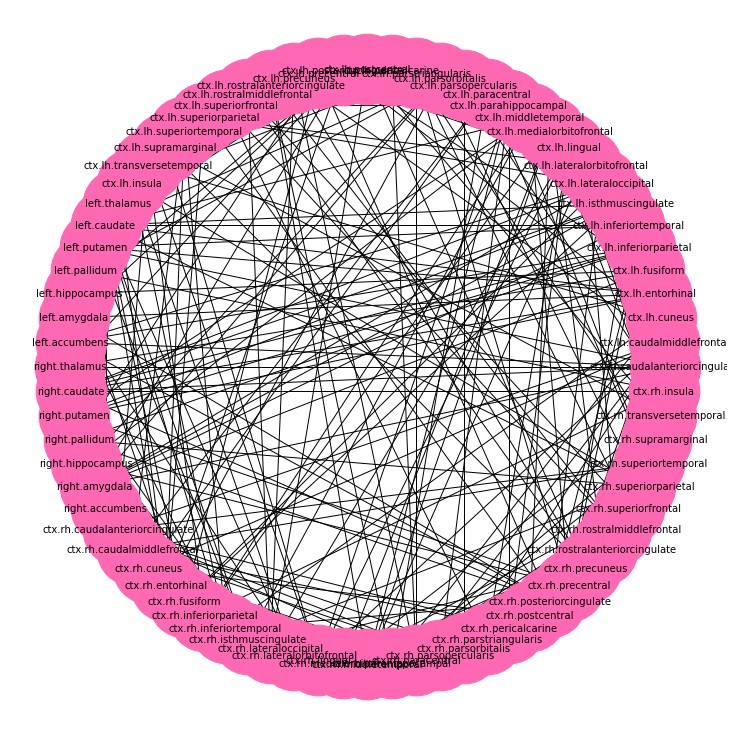

In [47]:
G_named_GM = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_named_GM.add_node(node_name) 

for node_id in model_GM.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_GM.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_GM.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_GM.number_of_nodes()}")
print(f"Número de aristas: {G_named_GM.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_GM)  # Disposición de los nodos
nx.draw(G_named_GM, pos, with_labels=True, node_size=5000, node_color="hotpink", font_size=10)
plt.show()

Número de nodos: 76
Número de aristas: 270


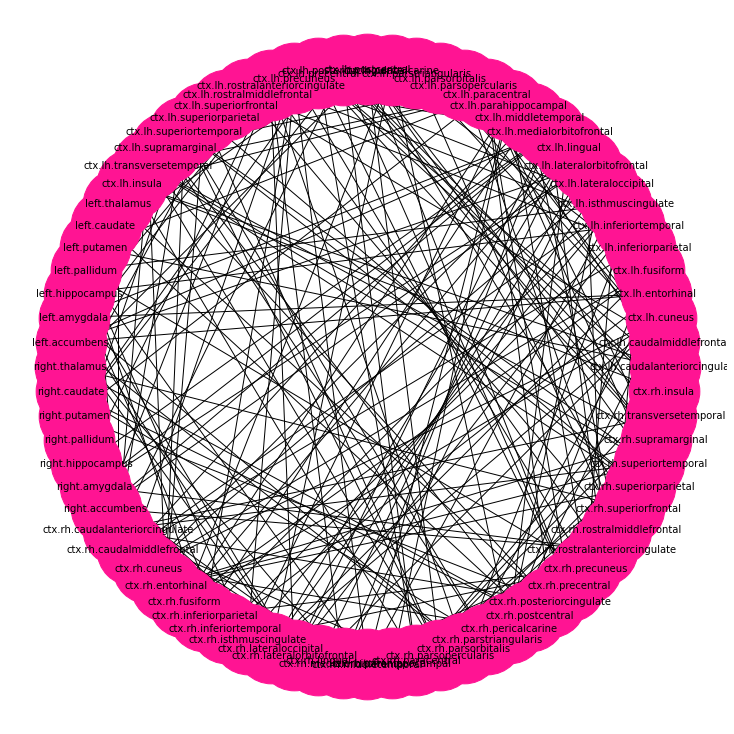

In [48]:
G_named_RS = nx.Graph()


for node_id, node_name in node_id_to_name.items():
    G_named_RS.add_node(node_name)  # Añadir el nodo usando su nombre

for node_id in model_RS.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_RS.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_RS.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_RS.number_of_nodes()}")
print(f"Número de aristas: {G_named_RS.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_RS)  
nx.draw(G_named_RS, pos, with_labels=True, node_size=5000, node_color="deeppink", font_size=10)
plt.show()

In [49]:
embeddings_FA_n2v = pd.DataFrame(embeddings_FA_n2v)
embeddings_FA_n2v.to_csv('embeddings_FA_n2v.csv', index=False)

embeddings_GM_n2v = pd.DataFrame(embeddings_GM_n2v)
embeddings_GM_n2v.to_csv('embeddings_GM_n2v.csv', index=False)

embeddings_RS_n2v = pd.DataFrame(embeddings_RS_n2v)
embeddings_RS_n2v.to_csv('embeddings_RS_n2v.csv', index=False)